In [8]:
# numpy_exact_sklearn_logreg.py
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import seaborn as sns

# -------------------------
# 0. Data (penguins)
# -------------------------
penguins = sns.load_dataset("penguins").dropna()
penguins["is_adelie"] = (penguins["species"] == "Adelie").astype(int)

X = penguins[["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]].values
y = penguins["is_adelie"].values.astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train).astype(np.float64)
X_test_scaled  = scaler.transform(X_test).astype(np.float64)

n_samples, n_features = X_train_scaled.shape

# -------------------------
# 1. Reference: sklearn LogisticRegression
# -------------------------
lr = LogisticRegression(penalty=None, solver="lbfgs", max_iter=50000)
lr.fit(X_train_scaled, y_train)

print("=== Scikit-learn Logistic Regression ===")
for name, coef in zip(["bill_length_mm","bill_depth_mm","flipper_length_mm","body_mass_g"], lr.coef_[0]):
    print(f"{name}: {coef:.12f}")
print(f"Intercept: {lr.intercept_[0]:.12f}\n")

# -------------------------
# 2. NumPy implementation of exact sklearn objective (logistic loss on margins)
#    using y in {-1, +1}
# -------------------------
# convert labels 0/1 -> -1/+1
y_signed = (2 * y_train - 1).astype(np.float64).reshape(-1)   # shape (n_samples,)

# helper: sigmoid
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

# objective: L(w,b) = mean( log(1 + exp(-y*(Xw + b))) )
def obj_and_grad(theta):
    # theta: length n_features + 1, last element = bias
    w = theta[:n_features]        # shape (n_features,)
    b = theta[n_features]         # scalar

    logits = X_train_scaled.dot(w) + b             # shape (n_samples,)
    margin = y_signed * logits                     # y * (Xw + b)

    # To avoid overflow, compute log(1+exp(-margin)) stably using np.logaddexp
    per_sample_loss = np.logaddexp(0.0, -margin)   # log(1 + exp(-margin))
    loss = per_sample_loss.mean()                  # scalar

    # gradient:
    # s = sigmoid(-margin) = 1 / (1 + exp(margin))
    s = 1.0 / (1.0 + np.exp(margin))               # shape (n_samples,)
    # grad_w = -(1/n) * X^T (y * s)
    ys = y_signed * s                              # shape (n_samples,)
    grad_w = - (X_train_scaled.T @ ys) / n_samples # shape (n_features,)
    grad_b = - ys.mean()                           # scalar

    grad = np.concatenate([grad_w, np.array([grad_b])])
    return float(loss), grad

# -------------------------
# 3. Run SciPy minimize with analytic gradient
# -------------------------
theta0 = np.zeros(n_features + 1, dtype=np.float64)

res = minimize(
    fun=lambda t: obj_and_grad(t)[0],
    x0=theta0,
    jac=lambda t: obj_and_grad(t)[1],
    method='L-BFGS-B',
    options={
        'maxiter': 50000,
        'ftol': 1e-14,
        'gtol': 1e-14,
        'maxcor': 50
    }
)

theta_opt = res.x
w_opt = theta_opt[:n_features]
b_opt = theta_opt[n_features]

print("Optimization success:", res.success, res.message)
print()

print("=== NumPy L-BFGS Logistic Regression (exact sklearn objective) ===")
for name, coef in zip(["bill_length_mm","bill_depth_mm","flipper_length_mm","body_mass_g"], w_opt):
    print(f"{name}: {coef:.12f}")
print(f"Intercept: {b_opt:.12f}\n")

# -------------------------
# 4. Compare
# -------------------------
coef_skl = np.concatenate([lr.coef_.flatten(), lr.intercept_])
coef_np  = np.concatenate([w_opt, [b_opt]])

print("Max coefficient abs diff:", np.max(np.abs(coef_skl - coef_np)))
print("Max probability abs diff on test set:")

# probabilities on test set
logits_test = X_test_scaled.dot(w_opt) + b_opt
prob_np = 1.0 / (1.0 + np.exp(-logits_test))
prob_skl = lr.predict_proba(X_test_scaled)[:,1]

print(np.max(np.abs(prob_np - prob_skl)))

print("\nDetailed differences:")
feat_names = ["bill_length_mm","bill_depth_mm","flipper_length_mm","body_mass_g","intercept"]
for name, s_val, n_val in zip(feat_names, coef_skl, coef_np):
    print(f"{name:20s}: sklearn={s_val:.12f}, numpy={n_val:.12f}, diff={s_val - n_val:.3e}")

# optional accuracy check
yhat_np = (prob_np > 0.5).astype(int)
print("\nTrain acc (sklearn):", accuracy_score(y_train, lr.predict(X_train_scaled)))
print("Train acc (numpy):  ", accuracy_score(y_train, (1.0/(1.0+np.exp(-(X_train_scaled.dot(w_opt)+b_opt)))>0.5).astype(int)))
print("Test acc (sklearn):", accuracy_score(y_test, lr.predict(X_test_scaled)))
print("Test acc (numpy):  ", accuracy_score(y_test, yhat_np))


=== Scikit-learn Logistic Regression ===
bill_length_mm: -23.753517695635
bill_depth_mm: 14.861583752030
flipper_length_mm: 0.170904253444
body_mass_g: 4.507838996325
Intercept: -5.443560167729

Optimization success: True CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH

=== NumPy L-BFGS Logistic Regression (exact sklearn objective) ===
bill_length_mm: -23.838589322747
bill_depth_mm: 14.896298079949
flipper_length_mm: 0.189854621233
body_mass_g: 4.497745905596
Intercept: -5.456250803110

Max coefficient abs diff: 0.08507162711219607
Max probability abs diff on test set:
0.0008625409774441484

Detailed differences:
bill_length_mm      : sklearn=-23.753517695635, numpy=-23.838589322747, diff=8.507e-02
bill_depth_mm       : sklearn=14.861583752030, numpy=14.896298079949, diff=-3.471e-02
flipper_length_mm   : sklearn=0.170904253444, numpy=0.189854621233, diff=-1.895e-02
body_mass_g         : sklearn=4.507838996325, numpy=4.497745905596, diff=1.009e-02
intercept           : sklearn=-5.4

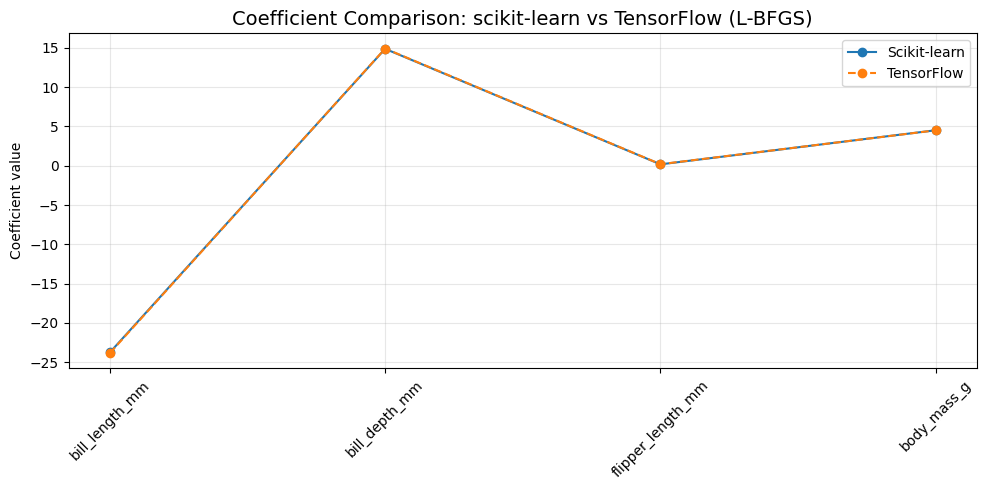

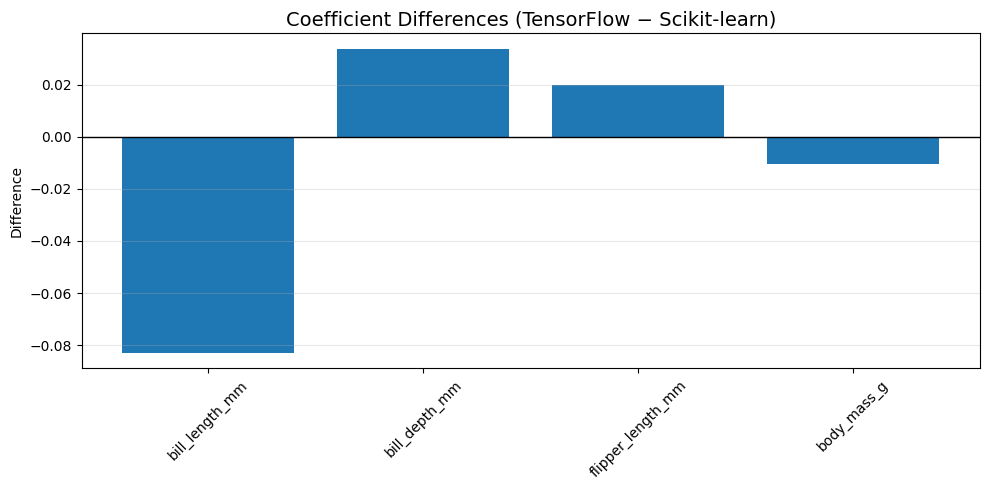

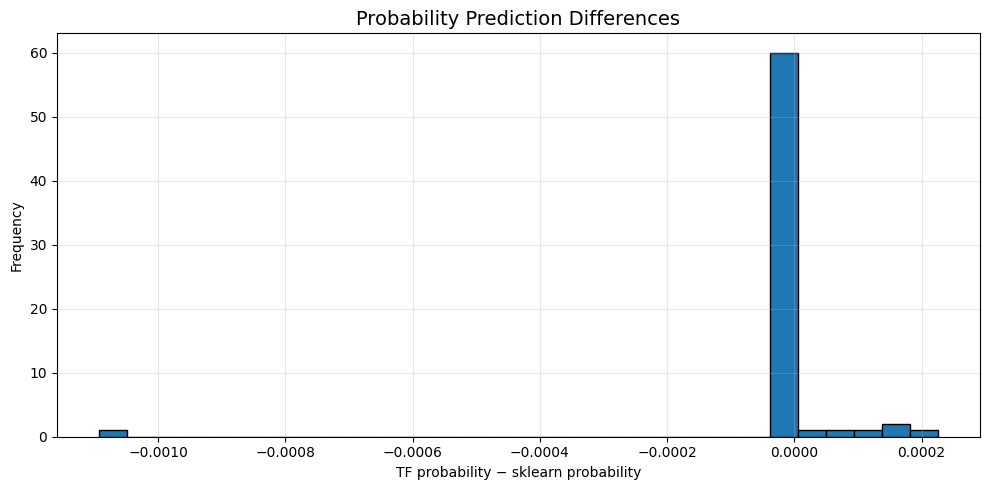

In [2]:
import matplotlib.pyplot as plt

# ---------------------------------------------------
# 1. Coefficient comparison plot
# ---------------------------------------------------
coeff_sklearn = lr.coef_.flatten()
coeff_tf = weights
features = X.columns

plt.figure(figsize=(10, 5))
plt.title("Coefficient Comparison: scikit-learn vs TensorFlow (L-BFGS)", fontsize=14)
plt.plot(features, coeff_sklearn, marker='o', label='Scikit-learn')
plt.plot(features, coeff_tf, marker='o', label='TensorFlow', linestyle='--')
plt.ylabel("Coefficient value")
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# ---------------------------------------------------
# 2. Difference bar plot
# ---------------------------------------------------
coef_diff = coeff_tf - coeff_sklearn

plt.figure(figsize=(10, 5))
plt.title("Coefficient Differences (TensorFlow − Scikit-learn)", fontsize=14)
bars = plt.bar(features, coef_diff)
plt.axhline(0, color='black', linewidth=1)
plt.ylabel("Difference")
plt.grid(True, axis='y', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# ---------------------------------------------------
# 3. Probability difference histogram
# ---------------------------------------------------
prob_diff = prob_tf - prob_lr

plt.figure(figsize=(10, 5))
plt.title("Probability Prediction Differences", fontsize=14)
plt.hist(prob_diff, bins=30, edgecolor='black')
plt.xlabel("TF probability − sklearn probability")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
